請你幫我製作玉米期貨的PnL (profit and loss) curve，為了幫助理解這個問題，可以依據以下的步驟進行。

1. 在每個交易日，皆存在著不同到期日的合約。在你分析的商品中，哪些到期月份的合約的交易量是最大的？

2. 市場慣性交易熱門月的合約，在每個交易日，請以最接近到期的熱門月合約做為持倉依據。

3. 請製作出一個函數，能給定在到期日前N日進行轉倉(rolling)，以收盤價計算出每日損益 (daily return)。

4. 請注意，在轉倉日時，會有相對應的轉倉成本，請思考該如何正確地估計它，可能為正或負，請將它計入每日損益。

5. 最後，請將每日損益進行累積和(cumulative sum)，並將圖畫出來，並將其與單純價格的pnl比較：請問你處理的商品的轉倉成本是偏正還是偏負？是什麼原因影響了轉倉成本？請將你做的曲線以及發現記錄下來。

In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas.tseries.offsets import BDay  # not include national holidays, etc
from dateutil.relativedelta import relativedelta

In [161]:
corn_data = pd.read_csv('contracts_c_corn.csv')
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN


In [162]:
corn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75302 entries, 0 to 75301
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 75302 non-null  object 
 1   Date               75302 non-null  object 
 2   close              75302 non-null  float64
 3   open               75302 non-null  float64
 4   high               75302 non-null  float64
 5   low                75302 non-null  float64
 6   open_interest      75302 non-null  int64  
 7   volume             75302 non-null  int64  
 8   exp_date           72120 non-null  object 
 9   first_notice_date  26026 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 5.7+ MB


In [335]:
BNDate_list = []
for i in range(len(corn_data)):
    if datetime.strptime(corn_data['Date'][i], '%d/%m/%Y') not in BNDate_list:
        BNDate_list.append(datetime.strptime(corn_data['Date'][i], '%d/%m/%Y'))

print(BNDate_list)

[datetime.datetime(2000, 1, 3, 0, 0), datetime.datetime(2000, 1, 4, 0, 0), datetime.datetime(2000, 1, 5, 0, 0), datetime.datetime(2000, 1, 6, 0, 0), datetime.datetime(2000, 1, 7, 0, 0), datetime.datetime(2000, 1, 10, 0, 0), datetime.datetime(2000, 1, 11, 0, 0), datetime.datetime(2000, 1, 12, 0, 0), datetime.datetime(2000, 1, 13, 0, 0), datetime.datetime(2000, 1, 14, 0, 0), datetime.datetime(2000, 1, 18, 0, 0), datetime.datetime(2000, 1, 19, 0, 0), datetime.datetime(2000, 1, 20, 0, 0), datetime.datetime(2000, 1, 21, 0, 0), datetime.datetime(2000, 1, 24, 0, 0), datetime.datetime(2000, 1, 25, 0, 0), datetime.datetime(2000, 1, 26, 0, 0), datetime.datetime(2000, 1, 27, 0, 0), datetime.datetime(2000, 1, 28, 0, 0), datetime.datetime(2000, 1, 31, 0, 0), datetime.datetime(2000, 2, 1, 0, 0), datetime.datetime(2000, 2, 2, 0, 0), datetime.datetime(2000, 2, 3, 0, 0), datetime.datetime(2000, 2, 4, 0, 0), datetime.datetime(2000, 2, 7, 0, 0), datetime.datetime(2000, 2, 8, 0, 0), datetime.datetime(2000

In [163]:
def get_month(date_str):
    date_format = ('%d/%m/%Y')
    try:
        return datetime.strptime(date_str, date_format).month
    except:
        return 0

In [164]:
exp_month_list = []
for date in corn_data['exp_date']:
    exp_month_list.append(get_month(date))

In [165]:
corn_data['exp_month'] = exp_month_list
# corn_data['exp_month'] = corn_data['exp_month'].astype(str)
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,1
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,3
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,5
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,7


In [166]:
corn_by_month = corn_data.groupby('exp_month')['volume'].sum()
print(corn_by_month)

exp_month
0         11959
1         16404
3     254001474
5     194735570
7     252867657
9     146435091
11        14567
12    441062932
Name: volume, dtype: int64


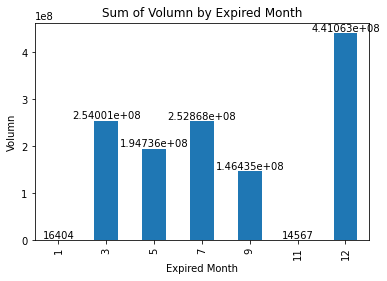

In [167]:
fig = corn_by_month[1:].plot(kind = 'bar')
fig.bar_label(fig.containers[0])
plt.title('Sum of Volumn by Expired Month')
plt.xlabel('Expired Month')
plt.ylabel('Volumn')
plt.show()

In [393]:
initialMargin = 2025
maintainMargin = 1500


fee = 1
corn_data['DailyReturn'] = 0
corn_data['CumReturn'] = -1 * fee

selected_Id = corn_data['maxVolume'].where(corn_data['maxVolume'] == True).first_valid_index()
print(corn_data.loc[selected_Id]['Id'])

CH00


In [415]:
dt_list = []
exp_dt_list = []

for i in range(len(corn_data)):
    try:
        dt_list.append(datetime.strptime(corn_data['Date'][i], '%d/%m/%Y'))
    except:
        dt_list.append(0)
    try:
        exp_dt_list.append(datetime.strptime(corn_data['exp_date'][i], '%d/%m/%Y'))
    except:
        exp_dt_list.append(0)
    
corn_data['dt'] = dt_list
corn_data['exp_dt'] = exp_dt_list
corn_data.tail()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume,CumReturn,dt,exp_dt
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,9,0,False,-1,2021-09-03,2023-09-14 00:00:00
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,12,0,True,-1,2021-09-03,2021-12-14 00:00:00
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,12,0,False,-1,2021-09-03,2022-12-14 00:00:00
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,12,0,False,-1,2021-09-03,2023-12-14 00:00:00
75301,CZ24,3/9/2021,4.3550,4.3500,4.3600,4.3500,1141,13,13/12/2024,29/11/2024,12,0,False,-1,2021-09-03,2024-12-13 00:00:00


In [420]:
BNidx_dt_dict = {i: obj for i, obj in enumerate(BNDate_list)}
BNdt_idx_dict = {obj: i for i, obj in enumerate(BNDate_list)}

In [450]:
fid = corn_data.loc[selected_Id]['Id']
fdt = corn_data.loc[selected_Id]['dt']
fp = corn_data.loc[selected_Id]['close']
next_dt = BNidx_dt_dict[BNdt_idx_dict[fdt] + 1]
next_p = corn_data['close'][(corn_data['Id'] == fid) & (corn_data['dt'] == next_dt)].values[0]

2.03

In [460]:
def DailyReturn(selected_Id):
    fid = corn_data.loc[selected_Id]['Id']
    fdt = corn_data.loc[selected_Id]['dt']
    fp = corn_data.loc[selected_Id]['close']
    next_dt = BNidx_dt_dict[BNdt_idx_dict[fdt] + 1]  # next business day
    next_p = corn_data['close'][(corn_data['Id'] == fid) & (corn_data['dt'] == next_dt)].values[0]  # same contract
    pnl = next_p - fp
    return pnl, fdt, next_dt

In [505]:
corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]

10

In [356]:
def next_business_date(old_date):
    '''input datetime.datetime'''
    new_date_upper = old_date + relativedelta(months = 1)
    y2 = new_date_upper.year
    m2 = new_date_upper.month
    first_bd = pd.date_range(datetime(y2, m2, 1, 0, 0, 0), new_date_upper, freq='BMS')[0]
    while first_bd not in BNDate_list:
        first_bd += relativedelta(days = 1)
    return first_bd

2001-01-02 00:00:00


In [548]:
BNDate_list[-1] + relativedelta(days = 1)

datetime.datetime(2021, 9, 4, 0, 0)

In [570]:
# 同一天(不管 Id)全都給一樣的 pnl
# 先不管手續費

selected_Id = corn_data['maxVolume'].where(corn_data['maxVolume'] == True).first_valid_index()
fid = corn_data.loc[selected_Id]['Id']

N = 1  # 提早 N 工作天轉倉
dailyReturn_list = [0] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[1]]  # first day has no return
expdt = corn_data.loc[selected_Id]['exp_dt']  # 14/3/2000
rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 13/3/2000
nearend=False

while len(dailyReturn_list) < len(corn_data):  # as long as the len of col is smaller than the len of the dataframe

    if nearend:
        print(selected_Id, corn_data.loc[selected_Id]['dt'])
    
    if corn_data.loc[selected_Id]['dt'] == BNDate_list[-2]:
        extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyReturn_list.extend(extend)
        
    elif len(corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]) & (corn_data['Id'] == fid)]) == 0:
        extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
        dailyReturn_list.extend(extend)
        
        p1 =  corn_data.loc[corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]]['close']  # 31/10/2011
        print('p1 =', p1)
        
        # 補 0
        idx1 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]).first_valid_index()
        idx2 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]).first_valid_index()
        extend0 = [0] * (idx2 - idx1)
        dailyReturn_list.extend(extend0)
        
        idx3 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 3]).first_valid_index()
        idx = corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]) & (corn_data['Id'] == fid)].index[0]
        p2 = corn_data.loc[idx]['close']
        print('p2 =', p2)
        
        
        extend = [(p2-p1)] * (idx3 - idx2)
        dailyReturn_list.extend(extend)
        
        selected_Id = corn_data[(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 2]) & (corn_data['Id'] == fid)].index[0]
        print(selected_Id)
    else:
    
        if DailyReturn(selected_Id)[2] != rolldt:
            extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
            dailyReturn_list.extend(extend)
            selected_Id = corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]

        else:
            # 轉倉
            tid = corn_data_vol['Id'][corn_data_vol['dt'] == DailyReturn(selected_Id)[2]].values[0]  # new contract Id
            tidx = corn_data_vol['index'][corn_data_vol['dt'] == DailyReturn(selected_Id)[2]].values[0]  # # new contract index on dt

            if tid == fid:
                # 如果沒有其他合約可以轉倉，下個月第一個工作天再入場，中間補 0

                extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyReturn_list.extend(extend)

                idx1 = corn_data['dt'].where(corn_data['dt'] == BNidx_dt_dict[BNdt_idx_dict[DailyReturn(selected_Id)[2]] + 1]).first_valid_index()
                nd1 = BNidx_dt_dict[BNdt_idx_dict[next_business_date(DailyReturn(selected_Id)[2])] + 1]
                idx2 = corn_data['dt'].where(corn_data['dt'] == nd1).first_valid_index()
                extend0 = [0] * (idx2 - idx1)
                dailyReturn_list.extend(extend0)

                selected_Id = corn_data_vol['index'][corn_data_vol['dt'] == next_business_date(DailyReturn(selected_Id)[2])].values[0]

                fid = corn_data.loc[selected_Id]['Id']
                expdt = corn_data.loc[selected_Id]['exp_dt']  # 14/3/2001
                rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 13/3/2001
                print(fid)
                print(expdt)
                print(rolldt)

            else:
                fid = tid

                extend = [DailyReturn(selected_Id)[0]] * corn_data['dt'].value_counts()[DailyReturn(selected_Id)[2]]
                dailyReturn_list.extend(extend)
                selected_Id = tidx
                # selected_Id = corn_data[(corn_data['dt'] == DailyReturn(selected_Id)[2]) & (corn_data['Id'] == fid)].index[0]
                print(corn_data.loc[selected_Id]['Id'])
                expdt = corn_data.loc[selected_Id]['exp_dt']  # 12/5/2000
                print(expdt)
                try:
                    rolldt = BNidx_dt_dict[BNdt_idx_dict[expdt] - N]  # 11/5/2000
                except:
                    rolldt = BNDate_list[-1] + relativedelta(days = 1)
                    nearend = True
                print(rolldt)

dailyReturn_list

CK00
2000-05-12 00:00:00
2000-05-11 00:00:00
CN00
2000-07-14 00:00:00
2000-07-13 00:00:00
CZ00
2000-12-14 00:00:00
2000-12-13 00:00:00
CH01
2001-03-14 00:00:00
2001-03-13 00:00:00
CK01
2001-05-14 00:00:00
2001-05-11 00:00:00
CN01
2001-07-13 00:00:00
2001-07-12 00:00:00
CZ01
2001-12-14 00:00:00
2001-12-13 00:00:00
CH02
2002-03-14 00:00:00
2002-03-13 00:00:00
CK02
2002-05-14 00:00:00
2002-05-13 00:00:00
CN02
2002-07-12 00:00:00
2002-07-11 00:00:00
CZ02
2002-12-13 00:00:00
2002-12-12 00:00:00
CH03
2003-03-14 00:00:00
2003-03-13 00:00:00
CK03
2003-05-14 00:00:00
2003-05-13 00:00:00
CN03
2003-07-14 00:00:00
2003-07-11 00:00:00
CZ03
2003-12-12 00:00:00
2003-12-11 00:00:00
CH04
2004-03-12 00:00:00
2004-03-11 00:00:00
CK04
2004-05-14 00:00:00
2004-05-13 00:00:00
CZ04
2004-12-14 00:00:00
2004-12-13 00:00:00
CH05
2005-03-14 00:00:00
2005-03-11 00:00:00
CK05
2005-05-13 00:00:00
2005-05-12 00:00:00
CN05
2005-07-14 00:00:00
2005-07-13 00:00:00
CZ05
2005-12-14 00:00:00
2005-12-13 00:00:00
CH06
2006-

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.022499999999999964,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.007500000000000284,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.03249999999999975,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 0.015000000000000124,
 -0.012500000000000178,
 -0.012500000000000178,
 -0.012500000000000178,
 -0.012500000000000

In [571]:
len(corn_data)

75302

In [572]:
dailyReturn_list[36379:36407]

[-0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 -0.08000000000000007,
 0,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574,
 -0.019999999999999574]

In [575]:
corn_data['DailyReturn'] = dailyReturn_list
corn_data.tail()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume,CumReturn,dt,exp_dt
75297,CU23,3/9/2021,4.8225,4.8225,4.8225,4.8225,138,0,14/9/2023,31/8/2023,9,-0.015,False,-1,2021-09-03,2023-09-14 00:00:00
75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,12,-0.015,True,-1,2021-09-03,2021-12-14 00:00:00
75299,CZ22,3/9/2021,5.0150,5.0075,5.0675,5.0000,83775,8561,14/12/2022,30/11/2022,12,-0.015,False,-1,2021-09-03,2022-12-14 00:00:00
75300,CZ23,3/9/2021,4.7250,4.7175,4.7625,4.7150,4085,57,14/12/2023,30/11/2023,12,-0.015,False,-1,2021-09-03,2023-12-14 00:00:00
75301,CZ24,3/9/2021,4.3550,4.3500,4.3600,4.3500,1141,13,13/12/2024,29/11/2024,12,-0.015,False,-1,2021-09-03,2024-12-13 00:00:00


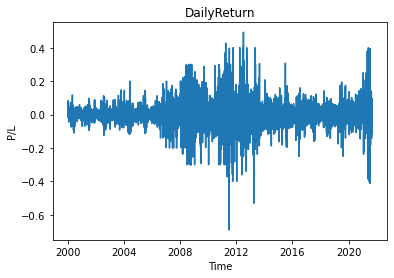

In [576]:
plt.plot(corn_data['dt'], corn_data['DailyReturn'])

plt.title('DailyReturn')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.show()

In [567]:
idx = corn_data.groupby(['Date'])['volume'].transform(max) == corn_data['volume']
corn_data[idx]

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume,CumReturn,dt,exp_dt
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3,0,True,-1,2000-01-03,2000-03-14 00:00:00
10,CH00,4/1/2000,2.0300,2.0075,2.0350,2.0075,0,34742,14/3/2000,NaN,3,0,True,-1,2000-01-04,2000-03-14 00:00:00
19,CH00,5/1/2000,2.0300,2.0250,2.0325,2.0100,0,29534,14/3/2000,NaN,3,0,True,-1,2000-01-05,2000-03-14 00:00:00
28,CH00,6/1/2000,2.0375,2.0300,2.0575,2.0300,0,36686,14/3/2000,NaN,3,0,True,-1,2000-01-06,2000-03-14 00:00:00
37,CH00,7/1/2000,2.0700,2.0325,2.0775,2.0250,0,46012,14/3/2000,NaN,3,0,True,-1,2000-01-07,2000-03-14 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,12,0,True,-1,2021-08-30,2021-12-14 00:00:00
75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,12,0,True,-1,2021-08-31,2021-12-14 00:00:00
75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,12,0,True,-1,2021-09-01,2021-12-14 00:00:00
75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,12,0,True,-1,2021-09-02,2021-12-14 00:00:00


In [381]:
corn_data['maxVolume'] = idx
corn_data.head()

,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume
0,CF01,3/1/2000,2.3275,2.3275,2.3275,2.3275,0,0,12/1/2001,NaN,1,0,False
1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3,0,True
2,CH01,3/1/2000,2.3975,2.4275,2.4275,2.3975,0,0,14/3/2001,NaN,3,0,False
3,CK00,3/1/2000,2.0800,2.1125,2.1225,2.0775,0,4414,12/5/2000,NaN,5,0,False
4,CN00,3/1/2000,2.1475,2.1775,2.1900,2.1450,0,7451,14/7/2000,NaN,7,0,False


In [453]:
# contracts with the max volume each day only

corn_data_vol = corn_data[idx].reset_index()
corn_data_vol.tail()

,index,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,maxVolume,CumReturn,dt,exp_dt
5628,75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,12,0,True,-1,2021-08-30,2021-12-14 00:00:00
5629,75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,12,0,True,-1,2021-08-31,2021-12-14 00:00:00
5630,75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,12,0,True,-1,2021-09-01,2021-12-14 00:00:00
5631,75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,12,0,True,-1,2021-09-02,2021-12-14 00:00:00
5632,75298,CZ21,3/9/2021,5.2400,5.2475,5.2800,5.2000,787405,108613,14/12/2021,30/11/2021,12,0,True,-1,2021-09-03,2021-12-14 00:00:00


In [377]:
def rolling(N, start_date = '3/1/2000', dataframe = corn_data_vol2):
    dailyReturn = [0] * (len(dataframe))
    
    start_date = datetime.strptime(start_date, '%d/%m/%Y')
    row1 = dataframe['dt'] == start_date  # 3/1/2000
    idx1 = dataframe[row1].index[0]  # 0
    running = True
    while running:

        d1_close = dataframe.iloc[idx1]['close']
               
        exp_date = datetime.strptime(dataframe.iloc[idx1]['exp_date'], '%d/%m/%Y')
        roll_date = exp_date - BDay(N)
        
        try:
            row2 = dataframe['dt'] == roll_date
            idx2 = dataframe[row2].index[0]
            exp_date2 = datetime.strptime(dataframe.iloc[idx2]['exp_date'], '%d/%m/%Y')
            if exp_date == exp_date2:
                
                start_date = next_business_date(roll_date)
                row1 = dataframe['dt'] == start_date
                idx1 = dataframe[row1].index[0]
            else:   
                
                d2_close = dataframe.iloc[idx2]['close']
                for i in range(idx2, len(dataframe)):
                    dailyReturn[i] += (d2_close - d1_close) * 5000

                start_date = roll_date
                row1 = dataframe['dt'] == start_date
                idx1 = dataframe[row1].index[0]
            
        except:
            print('error')
            running = False
        
    dataframe1 = dataframe.copy()
    dataframe1['DailyReturn'] = dailyReturn

    return dataframe1

In [378]:
df = rolling(4)
df

error


,index,Id,Date,close,open,high,low,open_interest,volume,exp_date,first_notice_date,exp_month,DailyReturn,dt,index_column
0,1,CH00,3/1/2000,2.0075,2.0450,2.0575,2.0050,0,44630,14/3/2000,NaN,3,0.0,2000-01-03,1
1,10,CH00,4/1/2000,2.0300,2.0075,2.0350,2.0075,0,34742,14/3/2000,NaN,3,0.0,2000-01-04,10
2,19,CH00,5/1/2000,2.0300,2.0250,2.0325,2.0100,0,29534,14/3/2000,NaN,3,0.0,2000-01-05,19
3,28,CH00,6/1/2000,2.0375,2.0300,2.0575,2.0300,0,36686,14/3/2000,NaN,3,0.0,2000-01-06,28
4,37,CH00,7/1/2000,2.0700,2.0325,2.0775,2.0250,0,46012,14/3/2000,NaN,3,0.0,2000-01-07,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5628,75242,CZ21,30/8/2021,5.4275,5.5300,5.5800,5.3675,785344,210911,14/12/2021,30/11/2021,12,14725.0,2021-08-30,75242
5629,75256,CZ21,31/8/2021,5.3425,5.4275,5.4550,5.2525,797196,192376,14/12/2021,30/11/2021,12,14725.0,2021-08-31,75256
5630,75270,CZ21,1/9/2021,5.2275,5.3475,5.3625,5.1825,793811,190162,14/12/2021,30/11/2021,12,14725.0,2021-09-01,75270
5631,75284,CZ21,2/9/2021,5.2550,5.2275,5.2825,5.1675,791701,134166,14/12/2021,30/11/2021,12,14725.0,2021-09-02,75284


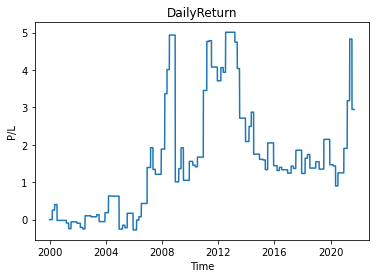

In [374]:
plt.plot(df['dt'], df['DailyReturn'])

plt.title('DailyReturn')
plt.xlabel('Time')
plt.ylabel('P/L')
plt.show()

In [109]:
def get_time_diff(date1, date2):
    date_format = ('%d/%m/%Y')
    try:
        return (datetime.strptime(date2, date_format) - datetime.strptime(date1, date_format)).days
    except:
        return float('-inf')

date_left_list = []
for r in range(len(corn_data)):
    date_left_list.append(get_time_diff(corn_data['Date'].iloc[r], corn_data['exp_date'].iloc[r]))
print(date_left_list[:20])

[375, 71, 436, 130, 193, 557, 255, 346, 711, 374, 70, 435, 129, 192, 556, 254, 345, 710, 373, 69]


In [159]:
def highest_vol_Id(dt):
    
    max_vol = corn_data.groupby('Date')['volume'].max()
    
    return corn_data[corn_data['volume'] == max_vol[dt]]['Id'].values[0]

highest_vol_Id('9/3/2001')

'CK01'

In [147]:
type(a['Id'])

pandas.core.series.Series

In [76]:
corn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75302 entries, 0 to 75301
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 75302 non-null  object 
 1   Date               75302 non-null  object 
 2   close              75302 non-null  float64
 3   open               75302 non-null  float64
 4   high               75302 non-null  float64
 5   low                75302 non-null  float64
 6   open_interest      75302 non-null  int64  
 7   volume             75302 non-null  int64  
 8   exp_date           72120 non-null  object 
 9   first_notice_date  26026 non-null  object 
 10  exp_month          75302 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 6.3+ MB
